## Wczytanie bibliotek

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import xgboost as xgb
import time

## Wczytanie danych
Dane będą wczytywane z różnych plików, zostaną wczytane dane treningowe oraz testowe. Plik test data zawiera wszelkie cechy oprócz nazwy pokemona.

In [2]:
train_data = pd.read_csv("data/train_data.csv")
test_part1 = pd.read_csv("data/test_data.csv")
test_part2 = pd.read_csv("data/test_pokemon.csv")
test_data = pd.concat([test_part1, test_part2], axis=1)

In [3]:
train_data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,59,Arcanine,Fire,NaN,555,82,110,88,105,72,98,1,False
1,107,Hitmonchan,Fighting,NaN,455,47,97,84,27,121,79,1,False
2,123,Scyther,Bug,Flying,500,63,113,86,56,73,109,1,False
3,35,Clefairy,Fairy,NaN,323,67,54,46,58,62,36,1,False
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,97,193,102,157,98,133,1,True


In [4]:
test_data['Total'] = test_data['HP'] + test_data['Attack'] + test_data['Defense'] + test_data['Sp. Atk'] + test_data['Sp. Def'] + test_data['Speed']
test_data.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Name,Total
0,Grass,Poison,79,103,119,123,116,85,1,False,VenusaurMega Venusaur,625
1,Fairy,NaN,69,35,53,63,64,39,1,False,Clefairy,323
2,Water,NaN,39,41,45,43,42,90,1,False,Poliwag,300
3,Normal,NaN,52,51,46,45,42,52,1,False,Ditto,288
4,Water,Fighting,89,93,98,80,87,63,1,False,Poliwrath,510


## Przetworzenie danych

### Usunięcie brakujących wartości

In [5]:
print("Brakujące wartości dla danych treningowych:")
print(train_data.isna().sum()) 

Brakujące wartości dla danych treningowych:
#                0
Name             0
Type 1           0
Type 2        1760
Total            0
HP               0
Attack           0
Defense          0
Sp. Atk          0
Sp. Def          0
Speed            0
Generation       0
Legendary        0
dtype: int64


In [6]:
print("Brakujące wartości dla danych testowych:")
print(test_data.isna().sum())

Brakujące wartości dla danych testowych:
Type 1           0
Type 2        1350
HP               0
Attack           0
Defense          0
Sp. Atk          0
Sp. Def          0
Speed            0
Generation       0
Legendary        0
Name             0
Total            0
dtype: int64


In [7]:
train_notna_data = train_data.fillna("Other")
test_notna_data = test_data.fillna("Other")

In [8]:
print("Brakujące wartości dla danych treningowych:")
print(train_notna_data.isna().sum())

Brakujące wartości dla danych treningowych:
#             0
Name          0
Type 1        0
Type 2        0
Total         0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
dtype: int64


In [9]:
print("Brakujące wartości dla danych testowych:")
print(test_notna_data.isna().sum())

Brakujące wartości dla danych testowych:
Type 1        0
Type 2        0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
Name          0
Total         0
dtype: int64


### Usunięcie niepoprawny wartości

In [10]:
train_clean = train_notna_data[(train_notna_data.HP > 0) & (train_notna_data.Attack > 0) & (train_notna_data.Defense > 0)].reset_index(drop=True)

columns = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for column in columns:
    print(f"Wiersze w {column} które mają wartość poniżej lub równe 0: {len(train_clean[train_clean[column] <= 0])}")

Wiersze w Total które mają wartość poniżej lub równe 0: 0
Wiersze w HP które mają wartość poniżej lub równe 0: 0
Wiersze w Attack które mają wartość poniżej lub równe 0: 0
Wiersze w Defense które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Atk które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Def które mają wartość poniżej lub równe 0: 0
Wiersze w Speed które mają wartość poniżej lub równe 0: 0


In [11]:
test_clean = test_notna_data[(test_notna_data.HP > 0) & (test_notna_data.Attack > 0) & (test_notna_data.Defense > 0)].reset_index(drop=True)

columns = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for column in columns:
    print(f"Wiersze w {column} które mają wartość poniżej lub równe 0: {len(test_clean[test_clean[column] <= 0])}")

Wiersze w Total które mają wartość poniżej lub równe 0: 0
Wiersze w HP które mają wartość poniżej lub równe 0: 0
Wiersze w Attack które mają wartość poniżej lub równe 0: 0
Wiersze w Defense które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Atk które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Def które mają wartość poniżej lub równe 0: 0
Wiersze w Speed które mają wartość poniżej lub równe 0: 0


### Normalizacja danych

In [12]:
def transform_dataset(data):
    data.Legendary = data.Legendary.astype(int)
    label_enc = LabelEncoder()
    minmax_scaler = MinMaxScaler()
    df_cat = pd.DataFrame()
    for column in ['Name', 'Type 1', 'Type 2']:
        df_cat[column] = label_enc.fit_transform(data[column])
    df_num = data[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
    columns = df_num.columns
    np_num = minmax_scaler.fit_transform(df_num)
    df_num_norm = pd.DataFrame(np_num, columns=columns)
    df_prepared = pd.concat([df_num_norm, df_cat, data['Generation']], axis=1)
    return df_prepared

train_df = transform_dataset(train_clean)
test_df = transform_dataset(test_clean)

In [13]:
train_df.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Name,Type 1,Type 2,Generation
0,0.615385,0.318898,0.550505,0.459893,0.507614,0.488189,0.603896,6,5,8,1
1,0.444444,0.181102,0.484848,0.438503,0.111675,0.874016,0.480519,60,4,8,1
2,0.521368,0.244094,0.565657,0.449198,0.258883,0.496063,0.675325,133,0,4,1
3,0.218803,0.259843,0.267677,0.235294,0.269036,0.409449,0.201299,23,3,8,1
4,1.000000,0.377953,0.969697,0.534759,0.771574,0.692913,0.831169,92,12,3,1


In [14]:
test_df.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Name,Type 1,Type 2,Generation
0,0.735043,0.307087,0.515152,0.623656,0.597990,0.820312,0.522293,154,7,9,1
1,0.218803,0.267717,0.171717,0.268817,0.296482,0.414062,0.229299,23,3,8,1
2,0.179487,0.149606,0.202020,0.225806,0.195980,0.242188,0.554140,118,14,8,1
3,0.158974,0.200787,0.252525,0.231183,0.206030,0.242188,0.312102,28,10,8,1
4,0.538462,0.346457,0.464646,0.510753,0.381910,0.593750,0.382166,120,14,3,1


## Regresja dla zmiennej Total

### Podział danych

In [102]:
scores_total = {}
X_train, y_train = train_df.drop('Total', axis=1), train_clean.Total
X_test, y_test = test_df.drop('Total', axis=1), test_clean.Total

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3308, 10) (3308,)
(2541, 10) (2541,)


In [56]:
X_train_tsne_dict = {}
X_test_tsne_dict = {}
for k in [2, 4, 6, 8]:
    start = time.time()
    tsne = TSNE(n_components=k, method='exact', n_jobs=-1)
    X_train_tsne = tsne.fit_transform(X_train)
    X_test_tsne = tsne.fit_transform(X_test)
    X_train_tsne_dict[k] = X_train_tsne
    X_test_tsne_dict[k] = X_test_tsne
    stop = time.time()
    print(f"Liczba cech: {k} - czas: {stop - start} sec")

Liczba cech: 2 - czas: 275.8313043117523 sec
Liczba cech: 4 - czas: 422.56461119651794 sec
Liczba cech: 6 - czas: 451.9609341621399 sec
Liczba cech: 8 - czas: 460.13820934295654 sec


### Regresja liniowa

In [122]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [123]:
y_pred = lin_reg.predict(X_test)
scores_total["lin_reg"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_total['lin_reg'][0]}")
print(f"R-squared: {scores_total['lin_reg'][1]}")

MSE: 2.0923
R-squared: 0.9998


#### PCA

In [124]:
scores_total_pca = {}
for k in [2, 4, 6, 8]:
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_pca, y_train)
    y_pred = lin_reg.predict(X_test_pca)
    scores_total_pca[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_pca[k][0]}", end=' ')
    print(f"R-squared: {scores_total_pca[k][1]}, liczba cech po redukcji {k}")

MSE: 152.4775 R-squared: 0.9883, liczba cech po redukcji 2
MSE: 152.4775 R-squared: 0.9883, liczba cech po redukcji 4
MSE: 152.4775 R-squared: 0.9883, liczba cech po redukcji 6
MSE: 152.4775 R-squared: 0.9883, liczba cech po redukcji 8


In [125]:
df_lin_reg_pca = pd.DataFrame(scores_total_pca)
df_lin_reg_pca.index = ['MSE', 'R-squared']
df_lin_reg_pca

,2,4,6,8
MSE,152.4775,152.4775,152.4775,152.4775
R-squared,0.9883,0.9883,0.9883,0.9883


#### t-SNE

In [126]:
scores_total_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_tsne, y_train)
    y_pred = lin_reg.predict(X_test_tsne)
    scores_total_tsne[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), 
                            np.round(r2_score(y_true=y_test, y_pred=y_pred), 4))
    print(f"MSE: {scores_total_tsne[k][0]}", end=' ')
    print(f"R-squared: {scores_total_tsne[k][1]}, liczba cech po redukcji {k}")

MSE: 13028.904 R-squared: 0.0027, liczba cech po redukcji 2
MSE: 11256.9394 R-squared: 0.1383, liczba cech po redukcji 4
MSE: 11672.9256 R-squared: 0.1065, liczba cech po redukcji 6
MSE: 11986.6531 R-squared: 0.0824, liczba cech po redukcji 8


In [127]:
df_lin_reg_tsne = pd.DataFrame(scores_total_tsne)
df_lin_reg_tsne.index = ['MSE', 'R-squared']
df_lin_reg_tsne

,2,4,6,8
MSE,13028.9040,11256.9394,11672.9256,11986.6531
R-squared,0.0027,0.1383,0.1065,0.0824


### Regresja grzebietowa

In [128]:
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

Ridge()

In [129]:
y_pred = ridge_reg.predict(X_test)
scores_total["ridge"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_total['ridge'][0]}")
print(f"R-squared: {scores_total['ridge'][1]}")

MSE: 3.473
R-squared: 0.9997


#### PCA

In [130]:
scores_total_pca = {}
for k in [2, 4, 6, 8]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    ridge_reg = Ridge()
    ridge_reg.fit(X_train_pca, y_train)
    y_pred = ridge_reg.predict(X_test_pca)
    scores_total_pca[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_pca[k][0]}", end=' ')
    print(f"R-squared: {scores_total_pca[k][1]}, liczba cech po redukcji {k}")

MSE: 12952.9216 R-squared: 0.0085, liczba cech po redukcji 2
MSE: 1001.9875 R-squared: 0.9233, liczba cech po redukcji 4
MSE: 365.6994 R-squared: 0.972, liczba cech po redukcji 6
MSE: 153.7005 R-squared: 0.9882, liczba cech po redukcji 8


In [131]:
df_ridge_reg_pca = pd.DataFrame(scores_total_pca)
df_ridge_reg_pca.index = ['MSE', 'R-squared']
df_ridge_reg_pca

,2,4,6,8
MSE,12952.9216,1001.9875,365.6994,153.7005
R-squared,0.0085,0.9233,0.9720,0.9882


#### TSNE

In [132]:
scores_total_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    ridge_reg = Ridge()
    ridge_reg.fit(X_train_tsne, y_train)
    y_pred = ridge_reg.predict(X_test_tsne)
    scores_total_tsne[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_tsne[k][0]}", end=' ')
    print(f"R-squared: {scores_total_tsne[k][1]}, liczba cech po redukcji {k}")

MSE: 13028.904 R-squared: 0.0027, liczba cech po redukcji 2
MSE: 11256.9408 R-squared: 0.1383, liczba cech po redukcji 4
MSE: 11672.8917 R-squared: 0.1065, liczba cech po redukcji 6
MSE: 11986.5139 R-squared: 0.0824, liczba cech po redukcji 8


In [133]:
df_ridge_reg_tsne = pd.DataFrame(scores_total_tsne)
df_ridge_reg_tsne.index = ['MSE', 'R-squared']
df_ridge_reg_tsne

,2,4,6,8
MSE,13028.9040,11256.9408,11672.8917,11986.5139
R-squared,0.0027,0.1383,0.1065,0.0824


### Lasso

In [134]:
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

Lasso()

In [135]:
y_pred = lasso_reg.predict(X_test)
scores_total["lasso"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_total['lasso'][0]}")
print(f"R-squared: {scores_total['lasso'][1]}")

MSE: 174.0233
R-squared: 0.9867


#### PCA

In [136]:
scores_total_pca = {}
for k in [2, 4, 6, 8]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    lasso_reg = Lasso()
    lasso_reg.fit(X_train_pca, y_train)
    y_pred = lasso_reg.predict(X_test_pca)
    scores_total_pca[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_pca[k][0]}", end=' ')
    print(f"R-squared: {scores_total_pca[k][1]}, liczba cech po redukcji {k}")

MSE: 12952.4669 R-squared: 0.0085, liczba cech po redukcji 2
MSE: 1026.6236 R-squared: 0.9214, liczba cech po redukcji 4
MSE: 458.6463 R-squared: 0.9649, liczba cech po redukcji 6
MSE: 403.3173 R-squared: 0.9691, liczba cech po redukcji 8


In [137]:
df_lasso_reg_pca = pd.DataFrame(scores_total_pca)
df_lasso_reg_pca.index = ['MSE', 'R-squared']
df_lasso_reg_pca

,2,4,6,8
MSE,12952.4669,1026.6236,458.6463,403.3173
R-squared,0.0085,0.9214,0.9649,0.9691


#### t-SNE

In [138]:
scores_total_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    lasso_reg = Lasso()
    lasso_reg.fit(X_train_tsne, y_train)
    y_pred = lasso_reg.predict(X_test_tsne)
    scores_total_tsne[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_tsne[k][0]}", end=' ')
    print(f"R-squared: {scores_total_tsne[k][1]}, liczba cech po redukcji {k}")

MSE: 13029.0321 R-squared: 0.0026, liczba cech po redukcji 2
MSE: 11257.0628 R-squared: 0.1383, liczba cech po redukcji 4
MSE: 11648.0144 R-squared: 0.1084, liczba cech po redukcji 6
MSE: 11927.401 R-squared: 0.087, liczba cech po redukcji 8


In [139]:
df_lasso_reg_tsne = pd.DataFrame(scores_total_tsne)
df_lasso_reg_tsne.index = ['MSE', 'R-squared']
df_lasso_reg_tsne

,2,4,6,8
MSE,13029.0321,11257.0628,11648.0144,11927.401
R-squared,0.0026,0.1383,0.1084,0.087


### Regresja xgboost

In [140]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [141]:
y_pred = xgb_reg.predict(X_test)
scores_total["xgb"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_total["xgb"][0]}")
print(f"R-squared: {scores_total["xgb"][1]}")

MSE: 127.6226
R-squared: 0.9902


#### PCA

In [142]:
scores_total_pca = {}
for k in [2, 4, 6, 8]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    xgb_reg = xgb.XGBRegressor()
    xgb_reg.fit(X_train_pca, y_train)
    y_pred = xgb_reg.predict(X_test_pca)
    scores_total_pca[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_pca[k][0]}", end=' ')
    print(f"R-squared: {scores_total_pca[k][1]}, liczba cech po redukcji {k}")

MSE: 206.4147 R-squared: 0.9842, liczba cech po redukcji 2
MSE: 30.2405 R-squared: 0.9977, liczba cech po redukcji 4
MSE: 39.4272 R-squared: 0.997, liczba cech po redukcji 6
MSE: 56.3285 R-squared: 0.9957, liczba cech po redukcji 8


In [143]:
df_xgb_reg_pca = pd.DataFrame(scores_total_pca)
df_xgb_reg_pca.index = ['MSE', 'R-squared']
df_xgb_reg_pca

,2,4,6,8
MSE,206.4147,30.2405,39.4272,56.3285
R-squared,0.9842,0.9977,0.9970,0.9957


#### t-SNE

In [144]:
scores_total_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    xgb_reg = xgb.XGBRegressor()
    xgb_reg.fit(X_train_tsne, y_train)
    y_pred = xgb_reg.predict(X_test_tsne)
    scores_total_tsne[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_tsne[k][0]}", end=' ')
    print(f"R-squared: {scores_total_tsne[k][1]}, liczba cech po redukcji {k}")

MSE: 19607.4963 R-squared: -0.5009, liczba cech po redukcji 2
MSE: 12812.8694 R-squared: 0.0192, liczba cech po redukcji 4
MSE: 14148.4082 R-squared: -0.083, liczba cech po redukcji 6
MSE: 12592.9818 R-squared: 0.036, liczba cech po redukcji 8


In [145]:
df_xgb_reg_tsne = pd.DataFrame(scores_total_tsne)
df_xgb_reg_tsne.index = ['MSE', 'R-squared']
df_xgb_reg_tsne

,2,4,6,8
MSE,19607.4963,12812.8694,14148.4082,12592.9818
R-squared,-0.5009,0.0192,-0.0830,0.0360


### Podsumowanie

In [171]:
df_total_scores = pd.DataFrame(scores_total)
df_total_scores.index = ['MSE', 'R-squared']
df_total_scores

,lin_reg,ridge,lasso,xgb
MSE,2.0923,3.4730,174.0233,127.6226
R-squared,0.9998,0.9997,0.9867,0.9902


Dla zadania przewidywania wartości zmiennej total najlepszymi metodami były liniowa regresja oraz regresja grzbietowa. Osiągneły bardzo niskie wartości metryki błędu średniokwadratowego. Dla tego zbioru metryka r kwadrat była dla każdej metody prawie jednakowa. Metoda Lasso oraz xgb zdecydowanie odstają od poprzednich metod. Warto pamiętać że zakres wartości Total waha się od 195 do 780, dlatego średni błąd ponad 100 jest dużą wartością.

C:\Users\urbii\AppData\Local\Temp\ipykernel_33752\3665573512.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_total_scores.loc['MSE'], palette=color_palette, ax=axes[0])
C:\Users\urbii\AppData\Local\Temp\ipykernel_33752\3665573512.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_total_scores.loc['R-squared'], palette=color_palette, ax=axes[1])


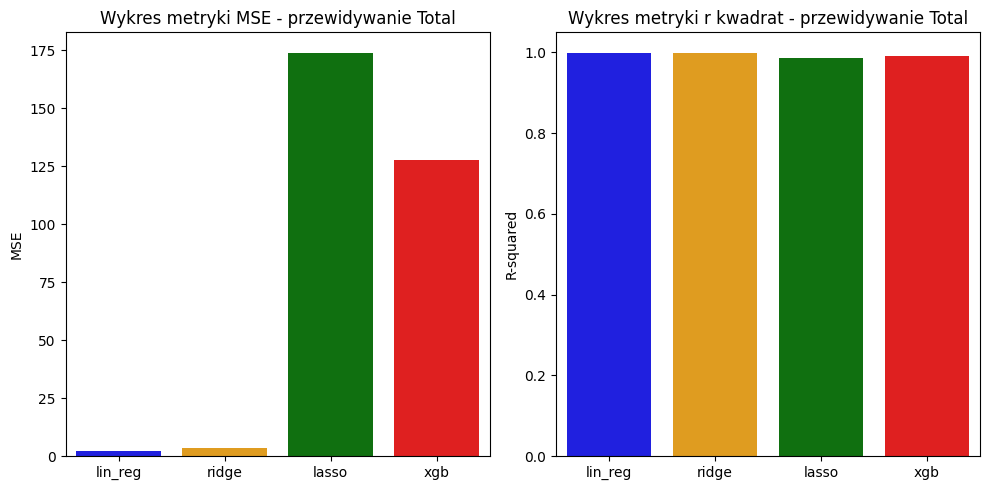

In [177]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
color_palette = ["blue", "orange", "green", "red"]

axes[0].set_title("Wykres metryki MSE - przewidywanie Total")
sns.barplot(df_total_scores.loc['MSE'], palette=color_palette, ax=axes[0])

plt.title("Wykres metryki r kwadrat - przewidywanie Total")
sns.barplot(df_total_scores.loc['R-squared'], palette=color_palette, ax=axes[1])

plt.tight_layout()
plt.show()

#### PCA

In [181]:
df_lasso_reg_pca[10] = scores_total["lasso"]
df_lasso_reg_pca["type"] = ["lasso", "lasso"]
df_lin_reg_pca[10] = scores_total["lin_reg"]
df_lin_reg_pca["type"] = ["lin_reg", "lin_reg"]
df_xgb_reg_pca[10] = scores_total["xgb"]
df_xgb_reg_pca["type"] = ["xgb", "xgb"]
df_ridge_reg_pca[10] = scores_total["ridge"]
df_ridge_reg_pca["type"] = ["ridge", "ridge"]

df_full_scores_total = pd.concat([df_ridge_reg_pca, df_xgb_reg_pca, df_lasso_reg_pca, df_lin_reg_pca])
df_full_scores_total["metric"] = df_full_scores_total.index
df_full_scores_total.set_index(["type", "metric"])

2          4         6         8        10
type    metric                                                        
ridge   MSE        12952.9216  1001.9875  365.6994  153.7005    3.4730
        R-squared      0.0085     0.9233    0.9720    0.9882    0.9997
xgb     MSE          206.4147    30.2405   39.4272   56.3285  127.6226
        R-squared      0.9842     0.9977    0.9970    0.9957    0.9902
lasso   MSE        12952.4669  1026.6236  458.6463  403.3173  174.0233
        R-squared      0.0085     0.9214    0.9649    0.9691    0.9867
lin_reg MSE          152.4775   152.4775  152.4775  152.4775    2.0923
        R-squared      0.9883     0.9883    0.9883    0.9883    0.9998

Jak można zauważyć wszystkie metody oprócz xgb utraciły na wykorzystaniu redukcji wymiarowości. Natomiast metoda xgb zyskała na redukcji cech do 4 (został zanotowany znaczący spadek błędu).

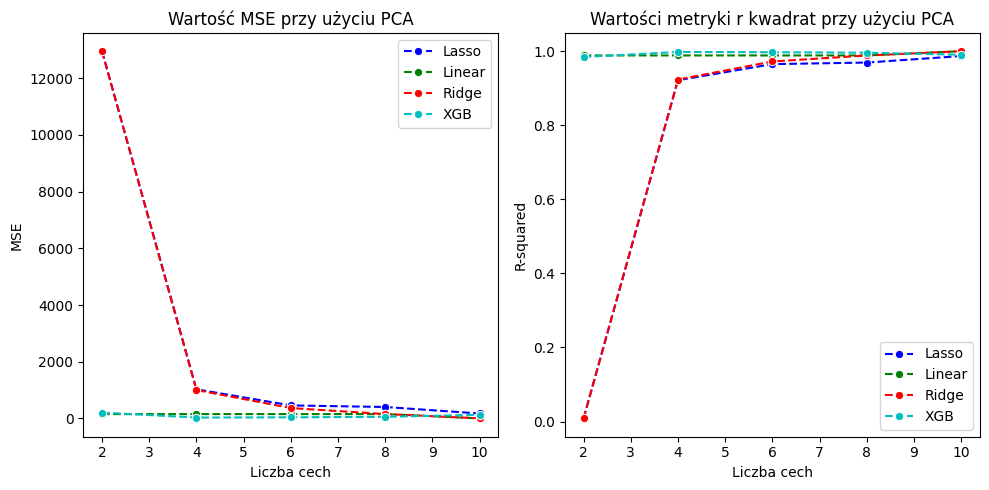

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title("Wartość MSE przy użyciu PCA")
sns.lineplot(data=df_lasso_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='b', label='Lasso', ax=axes[0])
sns.lineplot(data=df_lin_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='g', label='Linear', ax=axes[0])
sns.lineplot(data=df_ridge_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='r', label='Ridge', ax=axes[0])
sns.lineplot(data=df_xgb_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='c', label='XGB', ax=axes[0])
axes[0].set_xlabel("Liczba cech")
axes[0].set_ylabel("MSE")
axes[0].legend()

axes[1].set_title("Wartości metryki r kwadrat przy użyciu PCA")
sns.lineplot(data=df_lasso_reg_pca.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='b', label='Lasso', ax=axes[1])
sns.lineplot(data=df_lin_reg_pca.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='g', label='Linear', ax=axes[1])
sns.lineplot(data=df_ridge_reg_pca.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='r', label='Ridge', ax=axes[1])
sns.lineplot(data=df_xgb_reg_pca.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='c', label='XGB', ax=axes[1])
axes[1].set_xlabel("Liczba cech")
axes[1].set_ylabel("R-squared")
axes[1].legend()

plt.tight_layout()
plt.show()

#### t-SNE

In [182]:
df_lasso_reg_tsne[10] = scores_total["lasso"]
df_lasso_reg_tsne["type"] = ["lasso", "lasso"]
df_lin_reg_tsne[10] = scores_total["lin_reg"]
df_lin_reg_tsne["type"] = ["lin_reg", "lin_reg"]
df_xgb_reg_tsne[10] = scores_total["xgb"]
df_xgb_reg_tsne["type"] = ["xgb", "xgb"]
df_ridge_reg_tsne[10] = scores_total["ridge"]
df_ridge_reg_tsne["type"] = ["ridge", "ridge"]

df_full_scores_total_tsne = pd.concat([df_lasso_reg_tsne, df_lin_reg_tsne, df_xgb_reg_tsne, df_ridge_reg_tsne])
df_full_scores_total_tsne["metric"] = df_full_scores_total.index
df_full_scores_total_tsne.set_index(["type", "metric"])

2           4           6           8        10
type    metric                                                             
lasso   MSE        13029.0321  11257.0628  11648.0144  11927.4010  174.0233
        R-squared      0.0026      0.1383      0.1084      0.0870    0.9867
lin_reg MSE        13028.9040  11256.9394  11672.9256  11986.6531    2.0923
        R-squared      0.0027      0.1383      0.1065      0.0824    0.9998
xgb     MSE        19607.4963  12812.8694  14148.4082  12592.9818  127.6226
        R-squared     -0.5009      0.0192     -0.0830      0.0360    0.9902
ridge   MSE        13028.9040  11256.9408  11672.8917  11986.5139    3.4730
        R-squared      0.0027      0.1383      0.1065      0.0824    0.9997

Jak można zauważyć wyniki przy pomocy redukcji t-SNE są o wiele gorsze niż przy pomocy wszystkich cech czy też przy pomocy redukcji PCA. Dlatego raczej redukcję za pomocą t-SNE nalezy odrzucić. Trzeba również pamiętać o tym, że t-SNE jest o wiele dłuższą metodą. 

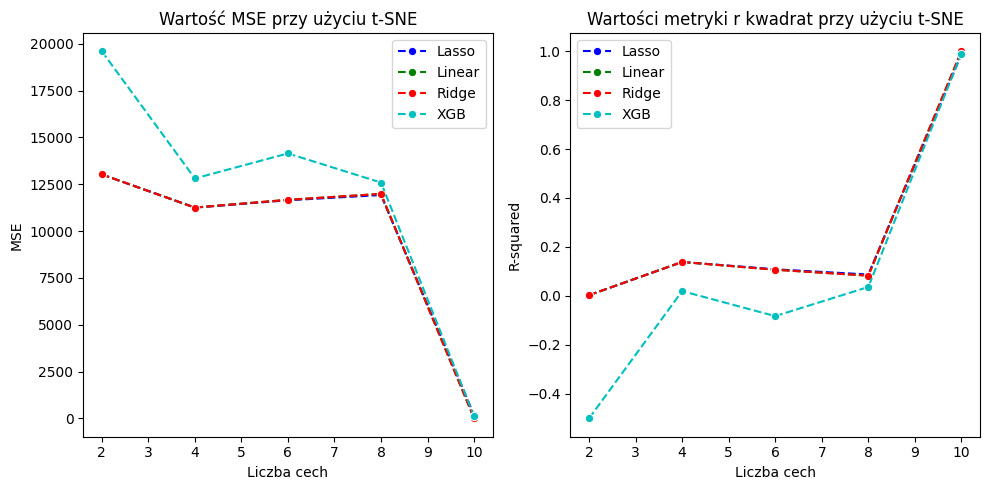

In [183]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title("Wartość MSE przy użyciu t-SNE")
sns.lineplot(data=df_lasso_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='b', label='Lasso', ax=axes[0])
sns.lineplot(data=df_lin_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='g', label='Linear', ax=axes[0])
sns.lineplot(data=df_ridge_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='r', label='Ridge', ax=axes[0])
sns.lineplot(data=df_xgb_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='c', label='XGB', ax=axes[0])
axes[0].set_xlabel("Liczba cech")
axes[0].set_ylabel("MSE")
axes[0].legend()

axes[1].set_title("Wartości metryki r kwadrat przy użyciu t-SNE")
sns.lineplot(data=df_lasso_reg_tsne.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='b', label='Lasso', ax=axes[1])
sns.lineplot(data=df_lin_reg_tsne.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='g', label='Linear', ax=axes[1])
sns.lineplot(data=df_ridge_reg_tsne.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='r', label='Ridge', ax=axes[1])
sns.lineplot(data=df_xgb_reg_tsne.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='c', label='XGB', ax=axes[1])
axes[1].set_xlabel("Liczba cech")
axes[1].set_ylabel("R-squared")
axes[1].legend()

plt.tight_layout()
plt.show()

## Regresja dla zmiennej HP

### Podział danych

In [169]:
scores_hp = {}
X_train, y_train = train_df.drop('HP', axis=1), train_clean.HP
X_test, y_test = test_df.drop('HP', axis=1), test_clean.HP

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3308, 10) (3308,)
(2541, 10) (2541,)


### Regresja liniowa

In [170]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [171]:
y_pred = lin_reg.predict(X_test)
scores_hp["lin_reg"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_hp["lin_reg"][0]}")
print(f"R-squared: {scores_hp["lin_reg"][1]}")

MSE: 2.0923
R-squared: 0.9972


### Regresja grzbietowa

In [172]:
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

Ridge()

In [173]:
y_pred = ridge_reg.predict(X_test)
scores_hp["ridge"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_hp['ridge'][0]}")
print(f"R-squared: {scores_hp['ridge'][1]}")

MSE: 32.7919
R-squared: 0.9565


### Lasso

In [174]:
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

Lasso()

In [175]:
y_pred = lasso_reg.predict(X_test)
scores_hp["lasso"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_hp['lasso'][0]}")
print(f"R-squared: {scores_hp['lasso'][1]}")

MSE: 506.1958
R-squared: 0.3289


### Regresja xgboost

In [177]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [178]:
y_pred = xgb_reg.predict(X_test)
scores_hp["xgb"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_hp["xgb"][0]}")
print(f"R-squared: {scores_hp["xgb"][1]}")

MSE: 27.2886
R-squared: 0.9638


### Podsumowanie

In [23]:
train_data["HP"].max()

np.int64(255)

In [179]:
df_hp_scores = pd.DataFrame(scores_hp)
df_hp_scores.index = ['MSE', 'R-squared']
df_hp_scores

,lin_reg,ridge,lasso,xgb
MSE,2.0923,32.7919,506.1958,27.2886
R-squared,0.9972,0.9565,0.3289,0.9638


Dla przewidywania zmiennej HP najlepszą metodą jest liniowa regresja, która zdecydowanie odbiega od innych metod. Nastepnie regresja grzbietowa oraz metoda xgb wypadły średnio. Najgorzej wypadła metoda Lasso, która prawdopobnie zwracała kompletne głupoty. Warto wspomnieć że wartości zmiennej HP wahały się od 0 do 255. Podsumowując, do tej pory najlepszą metodą okazała się regresja liniowa, która w obu przypadkach wypadła najlepiej.

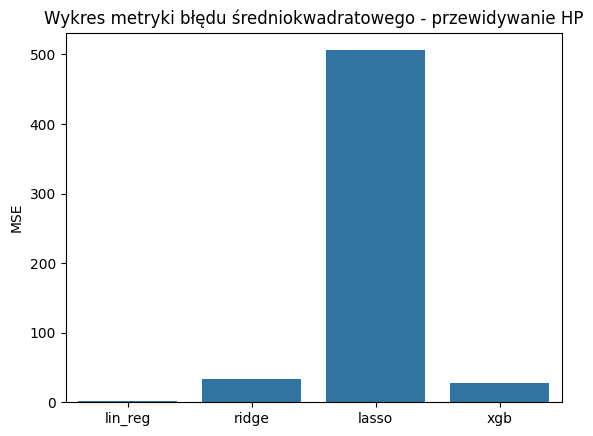

In [180]:
plt.title("Wykres metryki błędu średniokwadratowego - przewidywanie HP")
sns.barplot(df_hp_scores.loc['MSE'])
plt.show()

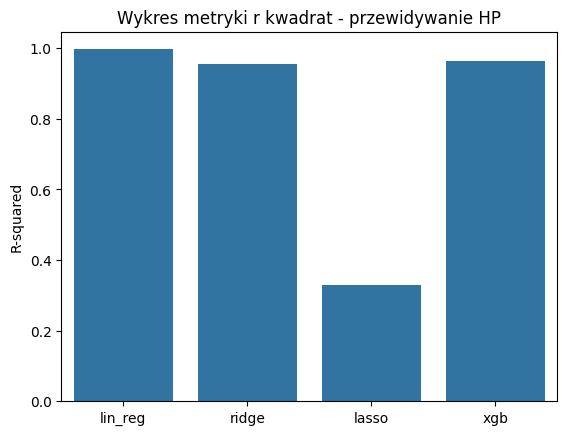

In [181]:
plt.title("Wykres metryki r kwadrat - przewidywanie HP")
sns.barplot(df_hp_scores.loc['R-squared'])
plt.show()